<a href="https://colab.research.google.com/github/Ignas12345/Project_in_Computational_Biology/blob/main/Part1_with_comparison_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook unifies the prievious notebooks into a single notebook.**

In [1]:
"""
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 20.22 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 204 (delta 48), reused 105 (delta 38), pack-reused 78
Receiving objects: 100% (204/204), 54.90 MiB | 23.08 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
import os
os.makedirs('DIP_images') #This folder will store images before the edge regularization
os.makedirs('Files_to_download') #This folder will store images of the edge map(/-s)
os.makedirs('Images_with_regularization') #This will store the images that we get after applying the edge map regularization

# Import libs

In [4]:
from Project_in_Computational_Biology.models import *
from PIL import Image
from Project_in_Computational_Biology.plotting import plot
from Project_in_Computational_Biology.converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from Project_in_Computational_Biology.models.downsampler import Downsampler
from EdgeNet.EdgeNet import EdgeNet

from Project_in_Computational_Biology.utils.sr_utils import *

#comment the following three lines if running on CPU

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark =True
#dtype = torch.cuda.FloatTensor

#and uncomment this line
dtype = torch.FloatTensor

upscaling_factor = 2

# Load image

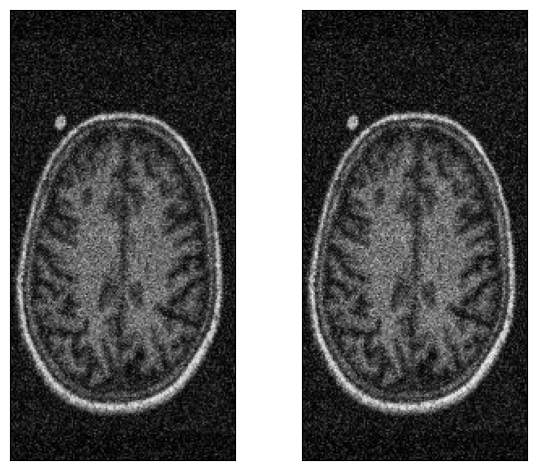

In [5]:
orig_img = Image.open('Project_in_Computational_Biology/pictures/images_with_ground_truth_2/Corrupted_2x.jpg')
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [11]:
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 100
reg_noise_std = 0.05

In [7]:
net_img = generate_noise(gray_img, upscaling_factor)
net_input = image_to_tensor(net_img).type(dtype).detach()
input_img = tensor_to_image(net_input)
input_img.save('Files_to_download/input_img.jpg')

In [8]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=upscaling_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [9]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('DIP_images/High_resolution_iteration_' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


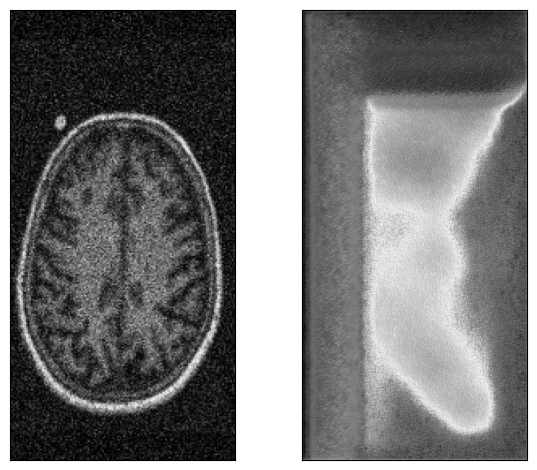

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25


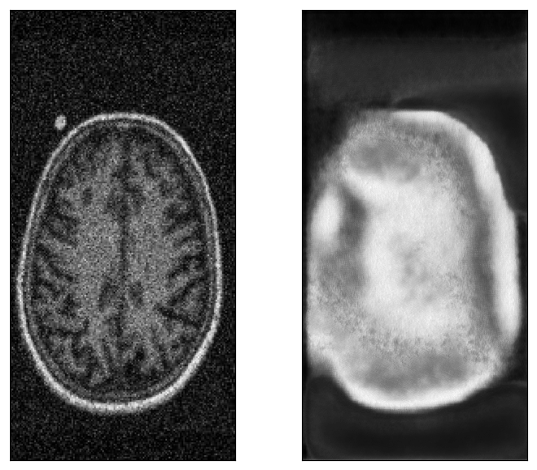

iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50


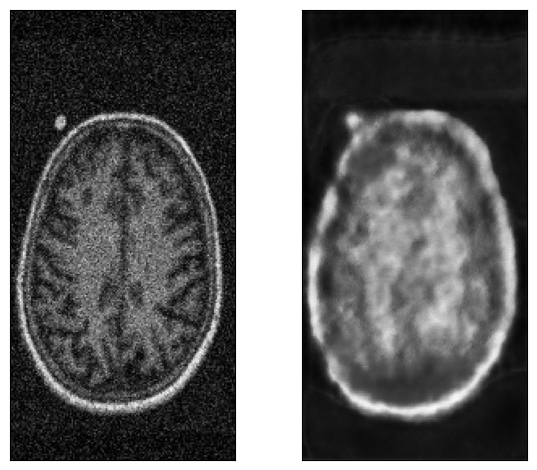

iteration: 51
iteration: 52
iteration: 53
iteration: 54


KeyboardInterrupt: 

In [12]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
torch.save(net.state_dict(), 'Files_to_download/model_parameters_DIP')

# Now get the edge map

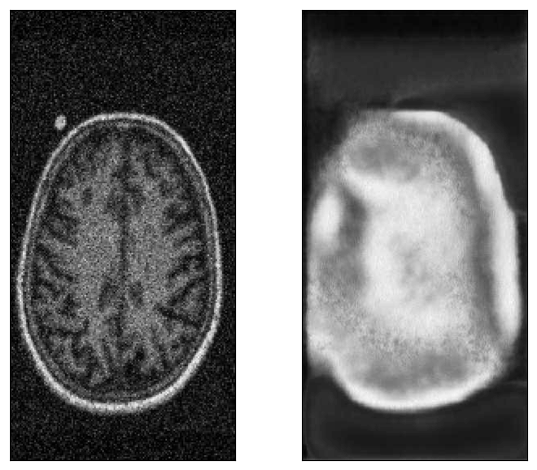

In [30]:
image_we_want_to_use = 25 #must be the number of the iteration that we consider not to have overfitted,  as we will drag back to it
underfitted_img = Image.open('DIP_images/High_resolution_iteration_' + str(image_we_want_to_use) + '.jpg')
overfitted_img = Image.open('DIP_images/High_resolution_iteration_' + str(50) + '.jpg')
plot([gray_img, underfitted_img], cmap='gray')

In [46]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
#Here you can choose which parameters of EdgeNet You want to use. Each can give different results. It becomes like a sort of game at this point...
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology/EdgeNet_parameters/model_parameters_3'))

<All keys matched successfully>

In [47]:
underfitted_edges_HR = edgenet(image_to_tensor(underfitted_img).type(dtype)).type(dtype).detach()
underfitted_edges_HR_img = tensor_to_image(underfitted_edges_HR)
underfitted_edges_LR = downsampler(underfitted_edges_HR).type(dtype).detach()
underfitted_edges_LR_img = tensor_to_image(underfitted_edges_LR)

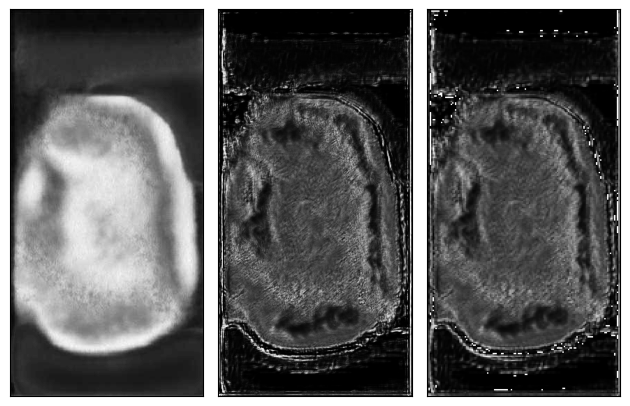

In [48]:
plot([underfitted_img, underfitted_edges_HR_img, underfitted_edges_LR_img], cmap = 'gray')

In [49]:
underfitted_edges_HR_img.save('Files_to_download/underfitted_edges_HR.jpg')
underfitted_edges_LR_img.save('Files_to_download/underfitted_edges_LR.jpg')

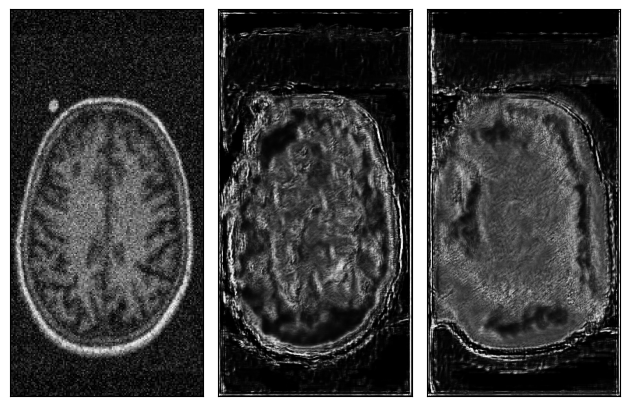

In [51]:
#here you can see how the overfitted edges would look
overfitted_edges_HR = edgenet(image_to_tensor(overfitted_img).type(dtype)).type(dtype).detach()
overfitted_edges_HR_img = tensor_to_image(overfitted_edges_HR)
plot([gray_img, overfitted_edges_HR_img, underfitted_edges_HR_img], cmap = 'gray')

In [52]:
# maybe you can use this value in the next notebook as a typical value for the edge loss?
mse(underfitted_edges_HR, overfitted_edges_HR)

tensor(0.0358)

#**Only run this part if you have access to the ground truth**

In [18]:
#Only run this part if you have access to the ground truth
ground_truth_img = Image.open('Project_in_Computational_Biology/pictures/images_with_ground_truth_2/Top_down_MRI_slice.jpg')
gray_ground_truth_img = turn_to_grayscale(ground_truth_img)
gray_ground_truth_tensor = image_to_tensor(gray_ground_truth_img)

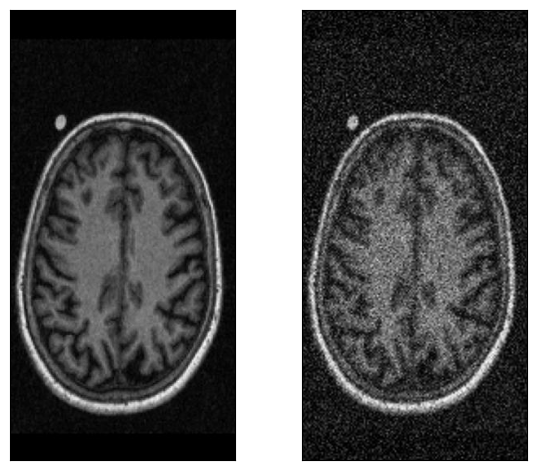

tensor(0.0069)

In [38]:
#here are the upscalings
bicubic_upscaling_img = gray_img.resize(gray_ground_truth_img.size, Image.BICUBIC)
bicubic_upscaling_img.save('Files_to_download/bicubic_upscaling.jpg')
bicubic_upscaling_tensor = image_to_tensor(bicubic_upscaling_img)

plot([gray_ground_truth_img, bicubic_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, bicubic_upscaling_tensor)

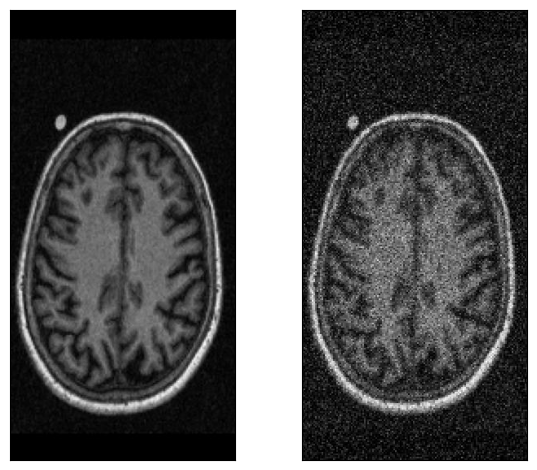

tensor(0.0094)

In [37]:
nearest_upscaling_img = gray_img.resize(gray_ground_truth_img.size, Image.NEAREST)
nearest_upscaling_img.save('Files_to_download/nearest_upscaling.jpg')
nearest_upscaling_tensor = image_to_tensor(nearest_upscaling_img)

plot([gray_ground_truth_img, nearest_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, nearest_upscaling_tensor)

In [23]:
import PIL

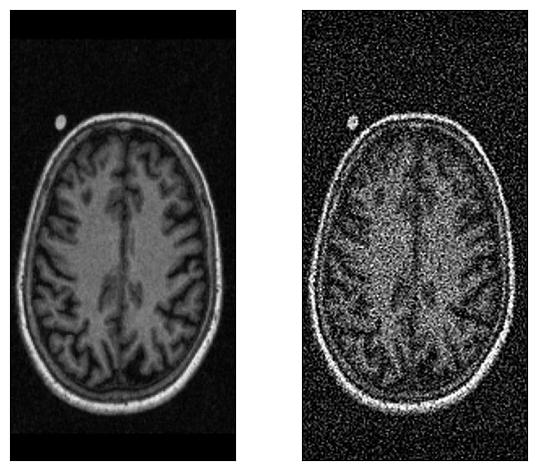

tensor(0.0209)

In [36]:
sharp_upscaling_img = bicubic_upscaling_img.filter(PIL.ImageFilter.UnsharpMask())
sharp_upscaling_img.save('Files_to_download/sharp_upscaling.jpg')
sharp_upscaling_tensor = image_to_tensor(sharp_upscaling_img)

plot([gray_ground_truth_img, sharp_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, sharp_upscaling_tensor)

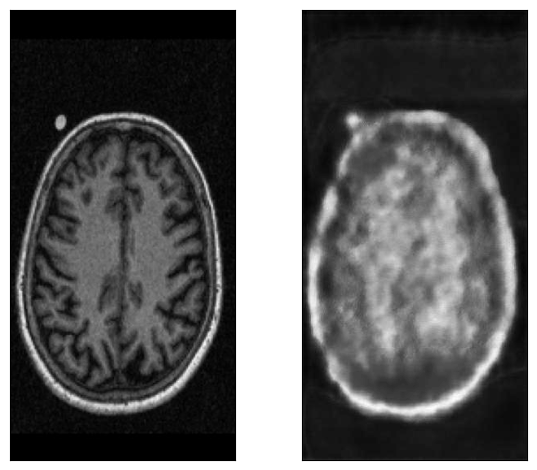

use this value for typical mse in part 2 : tensor(0.0308)


In [45]:
DIP_overfitted_upscaling_img = overfitted_img.resize(gray_ground_truth_img.size, Image.NEAREST)
DIP_overfitted_upscaling_tensor = image_to_tensor(DIP_overfitted_upscaling_img)

plot([gray_ground_truth_img, DIP_overfitted_upscaling_img], cmap='gray')
print('use this value for typical mse in part 2 : ' + str(mse(gray_ground_truth_tensor, DIP_overfitted_upscaling_tensor)))

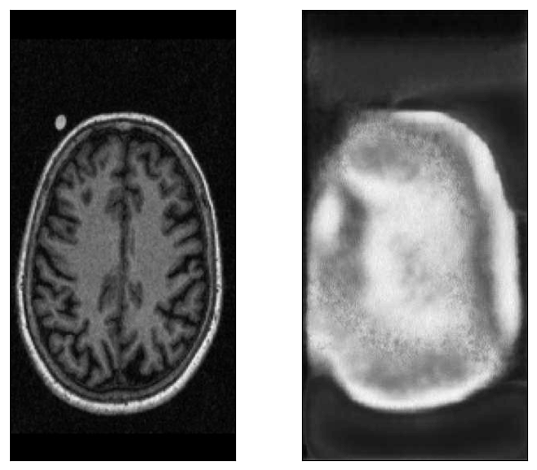

tensor(0.1088)

In [35]:
DIP_underfitted_upscaling_img = underfitted_img.resize(gray_ground_truth_img.size, Image.NEAREST)
DIP_underfitted_upscaling_tensor = image_to_tensor(DIP_underfitted_upscaling_img)

plot([gray_ground_truth_img, DIP_underfitted_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, DIP_underfitted_upscaling_tensor)

In [ ]:
edge_regulariztaion_upscaling_img = Image.open('High_resolution_iteration_after_edges3975.jpg')
edge_regulariztaion_upscaling_tensor = image_to_tensor(edge_regulariztaion_upscaling_img)

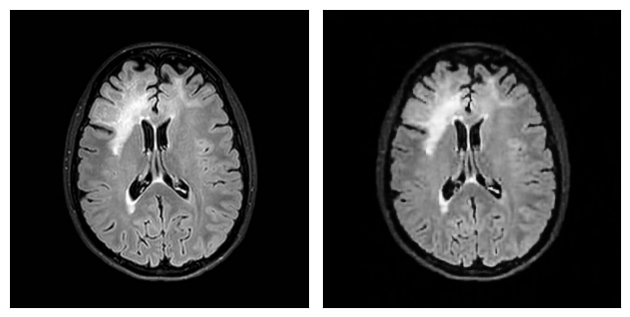

tensor(0.0009)

In [ ]:
plot([gray_ground_truth_img, edge_regulariztaion_upscaling_img], cmap='gray')
mse(gray_ground_truth_tensor, edge_regulariztaion_upscaling_tensor)